<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/main/experiments/mitb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# General imports

import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
# Custom Imports
COLAB = 'google.colab' in sys.modules
LOCAL = not COLAB

if COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/

    # Add custom modules to path
    custom_modules_path = '/content/visiope/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)

else:
    raise Exception("Unknown Environment")


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsSplitter, Ai4MarsDataloader

# Import Loss
import loss.loss

# Import Trainer
import trainer.trainer

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Dataloader

# Set this to True if you wnat to load directly the dataloader
# this can be done only on colab and it is useful to avoid runtime crash
LOAD = True

if LOAD and not LOCAL:

    if not(os.path.exists('/content/dataset/')):

        import gdown

        # get url of torch dataset (temporarerly my drive)
        drive = 'https://drive.google.com/uc?id='
        url = drive + '1agH_nuMOUaaVnX6_kzVu3me0lFHNU69L'

        # download dataloader on runtime env
        data_path = '/content/dataset/'
        gdown.download(url, data_path, quiet=False)

    dataloader = torch.load("/content/dataset/dataloader.pt")
    train_loader = dataloader[0]
    test_loader = dataloader[1]
    val_loader = dataloader[2]


elif LOCAL or not LOAD:

    # Insert here your local path to the dataset (temporary)
    data_path = input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = int(input("Number of images (max 1000): "))

    # Insert here your local path to the dataset (temporary)
    save_path = input("Path to Save the Dataset: ")

    if num_images > 1000 : raise Exception("Trying to import too many images")

    # Import data as Ai4MarsDataset
    importer = Ai4MarsDownload()
    X, y = importer(PATH=data_path, NUM_IMAGES=num_images)

    # Split the dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1])

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataloader()
    train_loader, test_loader, val_loader = loader([train_set, test_set, val_set], [32, 16, 16],
                                               SIZE=64, SAVE_PATH=save_path)


In [ ]:
print(len(test_loader.dataset))

print(test_loader.dataset.__getitem__(0)[0].shape)

In [ ]:
# Clone remote repo with existing models

!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .
%pip install -U gdown

In [9]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:00<00:00, 223MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [ ]:
#  Import segformer

from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B1',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

model.to(device)

print('Loaded Model')
print(model.backbone)

In [ ]:
PATH = '/content/drive/MyDrive/Models/MiT-B0/state_dict'
if os.path.exists(PATH):
    state_dict = torch.load(PATH)
    model.load_state_dict(state_dict)
    # Compare the model's state with the loaded state
    wmatch = True
    for key in state_dict:
        if not torch.equal(model.state_dict()[key], state_dict[key]):
            match = False
            break

    if wmatch:
        print("State loaded successfully")
    else:
        print("State loading failed")

In [15]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F



# based on:
# https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py

class DiceLoss(nn.Module):

    def __init__(self,device,stampa=True) -> None:
        super(DiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.device = device
        self.stampa = stampa

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:


        #errors:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))


        num_classes = input.shape[1]



        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # print("shape", input_soft.shape)



        input_soft = input_soft.permute(0,2,1,3)
        input_soft = input_soft.permute(0,1,3,2)

        # create the labels one hot tensor
        target_one_hot = F.one_hot(target, num_classes=input.shape[1])

        # target_one_hot = target_one_hot.permute(0,1,3,2)
        # target_one_hot = target_one_hot.permute(0,2,1,3)

        # print("target_one_hot",target_one_hot.shape)
        # print("input_soft",input_soft.shape)





        # compute the actual dice score
        dims = (1, 2, 3)
        intersection = torch.sum(input_soft.reshape(-1) * target_one_hot.reshape(-1), -1)
        cardinality = torch.sum(input_soft.reshape(-1) + target_one_hot.reshape(-1), -1)

        dice_score = 2. * intersection / (cardinality + self.eps)

        # if (self.stampa):
        #   print("outputs",input_soft)
        #   print("labels",target_one_hot)
        #   print((1. - dice_score).item())



        # print((1. - dice_score).shape)



        return 1. - dice_score

        #Alternative Universe

        # labels = target_one_hot
        # preds = input_soft

        # tp = torch.sum(labels*preds, dim=(2, 3))
        # fn = torch.sum(labels*(1-preds), dim=(2, 3))
        # fp = torch.sum((1-labels)*preds, dim=(2, 3))


        # delta = 0.5 # va messo come hyperparameter

        # dice_score = (tp + 1e-6) / (tp + delta * fn + (1 - delta) * fp + 1e-6)
        # dice_score = torch.sum(1 - dice_score, dim=-1)

        # dice_score = dice_score / num_classes
        # return dice_score.mean()







######################
# functional interface
######################


def dice_loss(
        input: torch.Tensor,
        target: torch.Tensor) -> torch.Tensor:
    r"""Function that computes Sørensen-Dice Coefficient loss.

    See :class:`~torchgeometry.losses.DiceLoss` for details.
    """
    return DiceLoss()(input, target)

In [16]:
import sys
import torch
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt


# This class collects all the training functionalities to train different models
class TmpTrainer():

    # Initialization of training parameters in the class constructor
    def __init__(self, loss_fn, optimizer, train_loader, test_loader,
                 device='cpu', save_state=None):
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.save_state = save_state
        self.loss_array=[]

    # This function implements training for just one epoch
    def train_one_epoch(self, model, epoch_index=0):
        accumulated_loss = 0.
        last_loss = 0.


        for batch_index, batch in enumerate(self.train_loader):
            # Every data instance is an (input, label) pair
            inputs, labels = batch

            # print("ORIGINAL INPUT -> ",inputs.shape)

            # Zero your gradients for every batch!
            self.optimizer.zero_grad()

            # Send inputs and labels to GPU
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            # Make predictions for this batch
            outputs = model(inputs)

            labels = labels.squeeze()
            labels = labels.long()


            #TEST WITH SMALL BATCH
            # outputs = outputs[:1,:,:4,:4]
            # labels = labels[:1,:4,:4]

            # Compute the loss and its gradients
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            self.optimizer.step()

            accumulated_loss += loss.item()
            #report_index = len(self.train_loader) -1

            # Free VRAM
            inputs.detach()
            labels.detach()
            del inputs
            del labels

        # Compute the average loss over all batches
        last_loss =  (accumulated_loss) /(batch_index+1)

        # Print report at the end of the last batch
        print(f'Epoch {epoch_index+1} loss: {last_loss}')

        return last_loss

    # This function implements training for multiple epochs
    def train_multiple_epoch(self, model, EPOCHS=100):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        epoch_number = 0 # just a counter
        best_tloss = 1_000_000.
        self.loss_array = []

        for epoch in range(EPOCHS):
            print(f'EPOCH: {epoch+1}')

            # Make sure gradient tracking is on, and do a pass over the data
            model.train()
            avg_loss = self.train_one_epoch(model, epoch)
            self.loss_array.append(avg_loss)

            # We don't need gradients on to do reporting
            # model.eval()

            # Test loss
            # accumulated_tloss = 0.0
            # for tbatch_index, tbatch in enumerate(self.test_loader):

            #     # Every data instance is a (input, label) pair
            #     tinputs, tlabels = tbatch

            #     # Send inputs and labels to GPU
            #     tinputs = tinputs.to(self.device)
            #     tlabels = tlabels.to(self.device)

            #     # Model prediction
            #     toutputs = model(tinputs)

            #     tlabels = tlabels.squeeze()
            #     tlabels = tlabels.long()

            #     # Run test loss
            #     test_loss = self.loss_fn(toutputs, tlabels)
            #     accumulated_tloss += test_loss.item()

            #     tinputs.detach()
            #     tlabels.detach()
            #     del tinputs
            #     del tlabels

            # Compute the average loss over all batches
            # avg_tloss = accumulated_tloss / (tbatch_index + 1)

            # # Print report at the end of the epoch
            # print(f'LOSS train {avg_loss} test {avg_tloss}')

            # # Track best performance, and save the model's state
            # if avg_tloss < best_tloss:
            #     best_tloss = avg_tloss
            #     model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            #     torch.save(model.state_dict(), model_path)

        if self.save_state:
            print(f'Saving model state in: {self.save_state}')
            torch.save(model.state_dict(), self.save_state)


if __name__ == '__main__':
    pass

In [21]:
# Define training parameters
#loss_fn =  torch.nn.CrossEntropyLoss().to(device)
loss_fn = DiceLoss(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_set = train_loader
test_set =  test_loader

trainer = TmpTrainer(loss_fn, optimizer, training_set, test_set, device,
                     save_state='/content/state_dict')

In [22]:
# START TRAIN
trainer.train_multiple_epoch(model, EPOCHS=100)

EPOCH: 1
Epoch 1 loss: 0.5803963298147375
EPOCH: 2
Epoch 2 loss: 0.5804506757042625
EPOCH: 3
Epoch 3 loss: 0.5799132504246451
EPOCH: 4
Epoch 4 loss: 0.5802766870368611
EPOCH: 5
Epoch 5 loss: 0.5798328952355818
EPOCH: 6
Epoch 6 loss: 0.5801295475526289
EPOCH: 7
Epoch 7 loss: 0.5800102515654131
EPOCH: 8
Epoch 8 loss: 0.5794994316317819
EPOCH: 9
Epoch 9 loss: 0.5806623182513497
EPOCH: 10
Epoch 10 loss: 0.5800105983560736
EPOCH: 11
Epoch 11 loss: 0.5804321982643821
EPOCH: 12
Epoch 12 loss: 0.5800830776041205
EPOCH: 13
Epoch 13 loss: 0.5802870907566764
EPOCH: 14
Epoch 14 loss: 0.580481540073048
EPOCH: 15
Epoch 15 loss: 0.5805081941864707
EPOCH: 16
Epoch 16 loss: 0.5798721801150929
EPOCH: 17
Epoch 17 loss: 0.5800425545735792
EPOCH: 18
Epoch 18 loss: 0.5801399512724443
EPOCH: 19
Epoch 19 loss: 0.5803087895566766
EPOCH: 20
Epoch 20 loss: 0.5797092372720892
EPOCH: 21
Epoch 21 loss: 0.5802055949514563
EPOCH: 22
Epoch 22 loss: 0.5799929120323875
EPOCH: 23
Epoch 23 loss: 0.5802896185354753
EPOCH: 

KeyboardInterrupt: ignored

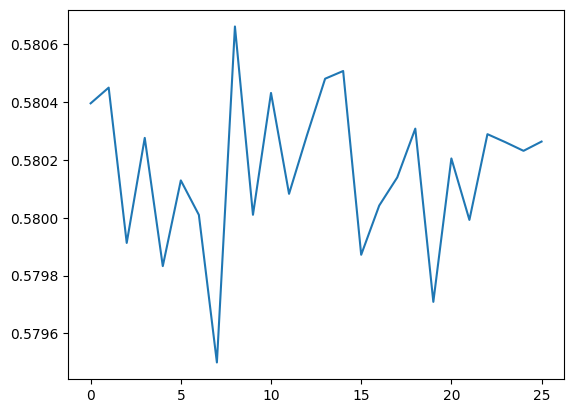

In [23]:
# Plot the histogram
plt.plot(np.array(trainer.loss_array))
plt.show()

In [28]:
import matplotlib.pyplot as plt

image, label = next(iter(val_loader))

'''print(f'image shape: {image.permute(0,2,1,3).permute(0,1,3,2).shape}')
plt.imshow(image[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'label shape: {label.permute(0,2,1,3).permute(0,1,3,2).shape}')
plt.imshow(label[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()'''

image = image.to(device)
label = label.to(device)

pred = model(image)

label = label.squeeze()
label = label.long()

print(f'prediction shape: {pred.shape}')
print(f'label shape: {label.shape}')

# label = label.type(torch.FloatTensor)
# pred = pred.type(torch.FloatTensor)

'''
The cross-entropy loss function will compute the element-wise softmax activation on the prediction
tensor along the class dimension to convert it into a probability distribution. It will then compare
this predicted probability distribution with the ground truth labels using the negative
log-likelihood loss calculation.

Therefore, even though the dimensions of the prediction and label tensors differ, the cross-entropy
loss function in PyTorch will appropriately handle the discrepancy and calculate the loss on a
per-pixel basis.
'''

print(f'loss : {loss_fn(pred, label)}')

'''
pred = pred.softmax(1).argmax(1).to(int)
pred.unique()

from semseg.datasets import *
palette = eval('ADE20K').PALETTE
seg_map = palette[pred.cpu()].squeeze().to(torch.uint8)

print(f'pred shape: {seg_map.shape}')
plt.imshow(seg_map[0], cmap='gray')
plt.show()'''


# # print(label.type())
# label = label.type(torch.FloatTensor)
# # print(label.type())

# print(f'pred shape: {pred.shape}')
# print(f'label shape: {label.shape}')

# plt.imshow(pred[0].cpu().detach().numpy(), cmap='gray')
# plt.show()

# s = torch.nn.Softmax(dim=1)
# new_pred = prediction.permute(0,2,1,3).permute(0,1,3,2)
# label = label.permute(0,2,1,3).permute(0,1,3,2)

# print()
# print(f'pred shape {new_pred.shape}')
# print(f'label shape {label.shape}')

# print(new_pred[0].argmax(dim=-1))
# print(label.squeeze(dim=-1)[0])

# print()
# # new_pred = new_pred.max(dim=-1)[0]
# new_pred = new_pred.to(device)
# label = label.to(device)

# print(f'pred shape {new_pred[0].shape}')
# print(f'label shape {label[0].shape}')

# print(f'pred shape {new_pred[0].shape}')

# print(loss_fn(new_pred, label))

# print(prediction.shape)
# new_prediction = torch.argmax(prediction, dim=1)
# print(f"prediction BEFORE shape -> {new_prediction.shape}")

# new_prediction = new_prediction[:,None, :, :]
# print(f"prediction AFTER shape -> {new_prediction.shape}")
# print(f"label shape -> {label.shape}")

# print(new_prediction.type())
# new_prediction = new_prediction.type(torch.FloatTensor)
# print(label.type())

# print(loss_fn(new_prediction, label))

# image.detach()
# label.detach()
# del label
# del image


prediction shape: torch.Size([16, 5, 64, 64])
label shape: torch.Size([16, 64, 64])
loss : 0.7086944580078125


"\npred = pred.softmax(1).argmax(1).to(int)\npred.unique()\n\nfrom semseg.datasets import *\npalette = eval('ADE20K').PALETTE\nseg_map = palette[pred.cpu()].squeeze().to(torch.uint8)\n\nprint(f'pred shape: {seg_map.shape}')\nplt.imshow(seg_map[0], cmap='gray')\nplt.show()"

In [ ]:
print(label.shape)
print(label[0])
tone = F.one_hot(label,num_classes=5).permute(0,3,1,2)
print(tone.shape)
print(tone[0][0])

In [ ]:
print(pred[0].shape)
tensore = F.softmax(pred[0],dim=0)

# print(torch.max(tensore,dim=0))
_,prediction_max = torch.max(tensore,dim=0)
print("prediction maxxxxxx ->",prediction_max)
print(torch.max(tensore[1]))
print(torch.max(tensore[2]))
print(torch.max(tensore[3]))
print(torch.max(tensore[4]))

torch.Size([5, 64, 64])
prediction maxxxxxx -> tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], device='cuda:0')
tensor(0.5662, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0031, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0020, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
print(pred[0][0])

tensor([[-8.2264, -8.2264, -7.6922,  ..., -4.6693, -4.6692, -4.6692],
        [-8.2264, -8.2264, -7.6922,  ..., -4.6693, -4.6692, -4.6692],
        [-8.2696, -8.2696, -7.7266,  ..., -5.2044, -5.2435, -5.2435],
        ...,
        [-6.0717, -6.0717, -6.1116,  ..., -5.9912, -6.0791, -6.0791],
        [-6.1123, -6.1123, -6.1797,  ..., -5.9829, -6.0477, -6.0477],
        [-6.1123, -6.1123, -6.1797,  ..., -5.9829, -6.0477, -6.0477]],
       device='cuda:0', grad_fn=<SelectBackward0>)


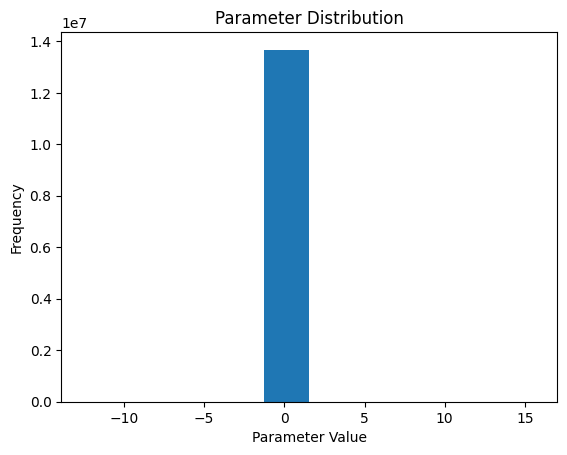

In [24]:
# TODO: plot the histogram
import numpy as np

# Obtain the parameter values from the trained model
parameters = []
for param in model.parameters():
    parameters.extend(param.cpu().flatten().detach().numpy())
parameters = np.array(parameters)

# Plot the histogram
plt.hist(parameters, bins=10)
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title('Parameter Distribution')
plt.show()